In [1]:
import cv2
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os
import scipy
import yaml
import random

In [2]:
count_figures = 0
all_positions_dict = {}
all_figures_dict = {}

In [3]:
def overlay(background, mask, mask_opacity=0.2, img_opacity=0.7):
    result = cv2.addWeighted(background, img_opacity, mask, mask_opacity, 0)
    plt.imshow(result, cmap='gray')
    plt.title('Check the mask')
    plt.show()

In [4]:
/home/sasha/WSLProjects/sem_simulator/data/in/bin_masks

SyntaxError: invalid syntax (4067801169.py, line 1)

In [28]:
path_to_dir= "../sem_simulator/data/in/"

den_dir = os.path.join(path_to_dir, 'denoised')

bin_dir = os.path.join(path_to_dir, 'iter2part12_part13_E200_G73_mask_scunet')
orig_dir = os.path.join(path_to_dir, 'raw')
# other = os.path.join(path_to_dir, 'mask_scunet_correct')
filenames_masks = os.listdir(bin_dir)
# filenames.sort()
print(f'Total: {len(filenames_masks)} files')
save_dir = os.path.join(path_to_dir, 'sem_mask')
os.makedirs(path_to_dir + '/sem_mask', exist_ok=True)

Total: 51 files


In [19]:
save_dir

'../sem_simulator/data/in/sem_mask'

In [20]:
def detect_contour(img):
    cont, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    cont_image = np.zeros_like(img)
    cv2.drawContours(cont_image, cont, -1, 255, 0)
    plt.imshow(cont_image) 
    
    return cont, cont_image

In [21]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    print(M['m10'], M['m00'])
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        cnt_norm = cnt - [cx, cy]
        cnt_scaled = cnt_norm * scale
        cnt_scaled = cnt_scaled + [cx, cy]
        cnt_scaled = cnt_scaled.astype(np.int32)

        return cnt_scaled
    return cnt

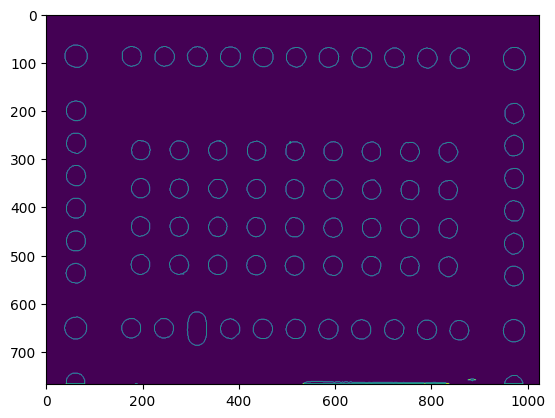

In [22]:
for file_name in filenames_masks:
    bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
    plt.imshow(bin_mask)
    cont, cont_image = detect_contour(bin_mask)
    test = np.zeros_like(bin_mask)
    

In [51]:
cv2.fillConvexPoly(test, cont // 2, 255)  # draws contour resized 1x/2

resized_contour = np.array(cont) * 2
cv2.polylines(test, [resized_contour], isClosed=True, color=255)  # draws contour resized 2x

plt.imshow(test)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

TypeError: unsupported operand type(s) for //: 'tuple' and 'int'

In [ ]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def contour_intersect(cnt_ref,cnt_query):

    ## Contour is a list of points
    ## Connect each point to the following point to get a line
    ## If any of the lines intersect, then break

    for ref_idx in range(len(cnt_ref)-1):
    ## Create reference line_ref with point AB
        A = cnt_ref[ref_idx][0]
        B = cnt_ref[ref_idx+1][0] 
    
        for query_idx in range(len(cnt_query)-1):
            ## Create query line_query with point CD
            C = cnt_query[query_idx][0]
            D = cnt_query[query_idx+1][0]
        
            ## Check if line intersect
            if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
                ## If true, break loop earlier
                return True

    return False

In [ ]:
def if_intersect(img):

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Проверка пересечения ограничивающих прямоугольников контуров
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i != j:  # Избегаем проверки контура на пересечение с самим собой
                rect1 = cv2.boundingRect(contour1)
                rect2 = cv2.boundingRect(contour2)
                intersection = not (rect1[0] + rect1[2] < rect2[0] or rect2[0] + rect2[2] < rect1[0] or
                                    rect1[1] + rect1[3] < rect2[1] or rect2[1] + rect2[3] < rect1[1])
                if intersection:
                    return True
    return False
                    # print("Контуры", i, "и", j, "пересекаются!")

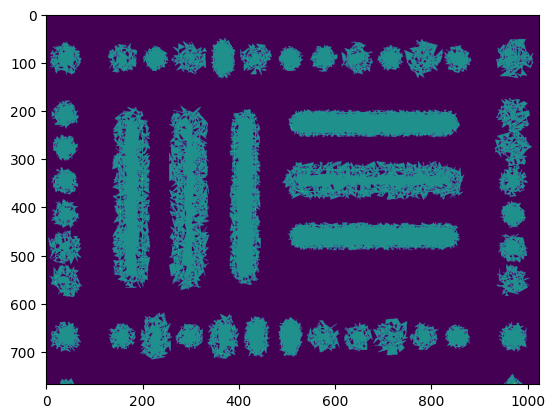

In [34]:
import cv2
import numpy as np

def contour_offset(src, offset):
    return [point + offset for point in src]

def scale_contour(src):
    scale_param = random.uniform(1.1, 1.48)

    rct = cv2.boundingRect(src)

    dc_contour = contour_offset(src, (-rct[0], -rct[1]))

    dc_contour_scale = [point * scale_param for point in dc_contour]

    # test = np.zeros((1024, 768))

    # print(type(dc_contour_scale))
    rct_scale = cv2.boundingRect(np.array(dc_contour_scale, dtype=np.int32))

    offset = ((rct[2] - rct_scale[2]) // 2, (rct[3] - rct_scale[3]) // 2)
    offset = tuple(np.subtract(offset, (-rct[0], -rct[1])))

    return contour_offset(dc_contour_scale, offset)

def scale_contours(src):
    return [scale_contour(contour) for contour in src]


def expand_contour(contour, expansion_amount):
    expanded_contour = []
    for point in contour:
        offset_x = random.randint(-expansion_amount, expansion_amount)
        offset_y = random.randint(-expansion_amount, expansion_amount)
        expanded_point = [point[0][0] + offset_x, point[0][1] + offset_y]
        expanded_contour.append([expanded_point])

    # cv2.drawContours(cont_image, expanded_contour, -1, 128, thickness=cv2.FILLED)
    return np.array([expanded_contour], dtype=np.int32)

# Example of usage
if __name__ == "__main__":
    # src = []  # Add your source contours

    for file_name in filenames_masks:
        bin_mask = cv2.imread(os.path.join(bin_dir, file_name), 0)
        cont, cont_image = detect_contour(bin_mask)

        for c in cont:
            expansion_amount = random.randint(5, 20)
            expanded = expand_contour(c, expansion_amount)
            cv2.drawContours(cont_image, expanded, -1, 128, thickness=cv2.FILLED)

        # dst = scale_contours(cont)
        # dst_np = [np.array(contour, dtype=np.int32) for contour in dst]

        # cv2.drawContours(cont_image, dst_np, -1, 128, -1)
        # cv2.drawContours(cont_image, cont, -1, 255, -1)

        plt.imshow(cont_image)
        # cv2.imwrite(os.path.join(save_dir, file_name), cont_image)



In [ ]:
import cv2
import numpy as np
import random

# Загрузка бинарной маски (предположим, что у вас уже есть бинарная маска)
# binary_mask = cv2.imread('binary_mask.png', cv2.IMREAD_GRAYSCALE)

# # Нахождение контуров на бинарной маске
# contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Создание пустого изображения того же размера, что и бинарная маска
# expanded_contours_mask = np.zeros_like(binary_mask)

# Функция для расширения контуров на рандомное количество пикселей
def expand_contour(contour, expansion_amount):
    # Преобразование контура в многоугольник
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    
    # Создание пустого изображения для контура
    contour_mask = np.zeros_like(binary_mask)
    
    # Нарисовать контур на изображении
    cv2.drawContours(contour_mask, [polygon], -1, 255, thickness=cv2.FILLED)
    
    # Расширение контура
    kernel = np.ones((3, 3), np.uint8)
    expanded_contour_mask = cv2.dilate(contour_mask, kernel, iterations=expansion_amount)
    
    return expanded_contour_mask

# Расширение каждого контура на рандомное количество пикселей
for contour in contours:
    # Выбор случайного количества пикселей для расширения
    expansion_amount = random.randint(5, 20)  # Можно изменить диапазон по вашему усмотрению
    
    # Расширение контура
    expanded = expand_contour(contour, expansion_amount)
    
    # Добавление расширенного контура к общему изображению
    expanded_contours_mask = cv2.bitwise_or(expanded_contours_mask, expanded)

# Отображение расширенных контуров
cv2.imshow('Expanded Contours', expanded_contours_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
random.uniform(1.05, 1.5)

1.2990500985087845

In [33]:
scaled_contour

array([[[185, 767]]], dtype=int32)